In [66]:
from __future__ import division
import utils
import pandas as pd
import numpy as np
import math
import datetime as dt

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import VarianceThreshold
# from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import lightgbm as lgb

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
# from sklearn import preprocessing

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
# np.set_printoptions(threshold=np.nan)  

#####################################################################################

def stratify_sampling(df, tot_out_rows, strat_col):
    rowspercol=round(tot_out_rows/df[strat_col].nunique())
    a=pd.DataFrame()
    
    for strata in range(0,df[strat_col].nunique()):
        print(strata)
        a=a.append(df[df[strat_col]==strata].sample(rowspercol))
        print (a.shape)
    return a.sample(tot_out_rows)

# Read dataset

In [67]:
df=pd.read_pickle('/home/gjain/df_cat_enc_part1.pkl')

In [63]:
df.target.value_counts()

0    1386632
1    2570   
Name: target, dtype: int64

In [64]:
#target, timestamp, order_number, pay_id not included below
#72 cols
all_cols=['affiliate','channelcode',
       'local_trans_amt', 'trans_currency', 'nonmor', 'payment_method', 'eci',
       'card_cvvmatch', 'card_avsmatch', 'customer_title', 'website_language',
       'brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion',
       'OriginSubRegion', 'DestinationAirportCode', 'DestinationCityName',
       'DestinationCountryName', 'DestinationWorldPartName',
       'DestinationRegion', 'DestinationSubRegion', 'Supplier',
       'DomesticOrInternational', 'Haul', 'OneWayOrReturn', 'IsCombinedOneWay',
       'IsITFare', 'TotalNumberOfPassengers', 'TotalNumberOfAdults',
       'TotalNumberOfChildren', 'TotalNumberOfInfants', 'COW_NumberOfSegments',
       'COW_NumberOfInboundSegments', 'COW_NumberOfOutboundSegments',
       'NumberOfTickets', 'FareBaseAmount', 'HasSplitPnr', 'DeviceType',
#        'OrderDateBrandTime_Month',
        'IsLowCost', 'email_user_id_len',
       'email_domain', 'dob_month', 'bookerIsTravelAgency',
       'successful_attempt_no', 'country_ip_flight_MatchScore',
       'flight_distance', 'days_to_departure', 'vacation_length',
       'cities_in_itinerary', 'cabin_class', 'name_len', 'weekend_booking',
       'booking_daytime', 'bookerAgeBracket', 'email_sanity_score',
          #new ad
         'OrderDateBrandTime_DayOfWeek',
         'ordermonth_sin','ordermonth_cos','departuremonth_sin','departuremonth_cos']

all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch',
              'customer_title','website_language','brand_continent','HasTicketInsurance','HasInsurance','HasBaggage',
              'HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender','BookerCity','BookerCountry_Name','airline',
              'Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName',
              'DestinationRegion','DestinationSubRegion','Supplier','DomesticOrInternational','Haul','OneWayOrReturn',
              'IsCombinedOneWay','IsITFare','HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class',
              'bookerIsTravelAgency','weekend_booking','dob_month','booking_daytime', 'bookerAgeBracket',
          'OrderDateBrandTime_DayOfWeek']

#Get location of loo_cols, our categorical columns, in df[all_cols], to feed in Pool
df2=df[all_cols]
categorical_features_pos=[df2.columns.get_loc(c) for c in all_cat_cols]
categorical_features_pos

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 52,
 53,
 54,
 56,
 65,
 58,
 67,
 57,
 68,
 69,
 71]

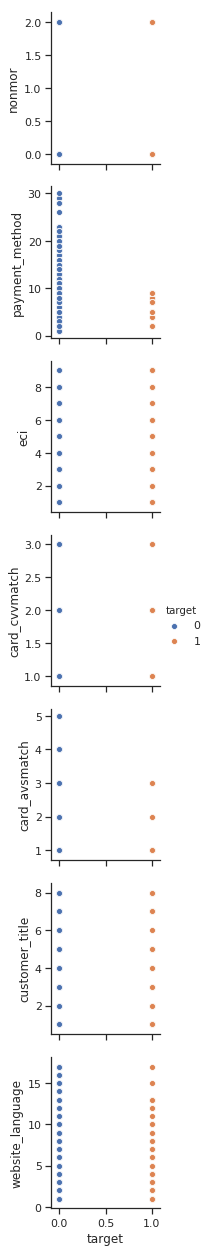

In [70]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib as plt
%matplotlib inline

sampler = RandomUnderSampler({1: 2570 , 0: 50000}, random_state=16)

X, y = sampler.fit_sample(df, df.target)
X=pd.DataFrame(X, columns=df.columns)


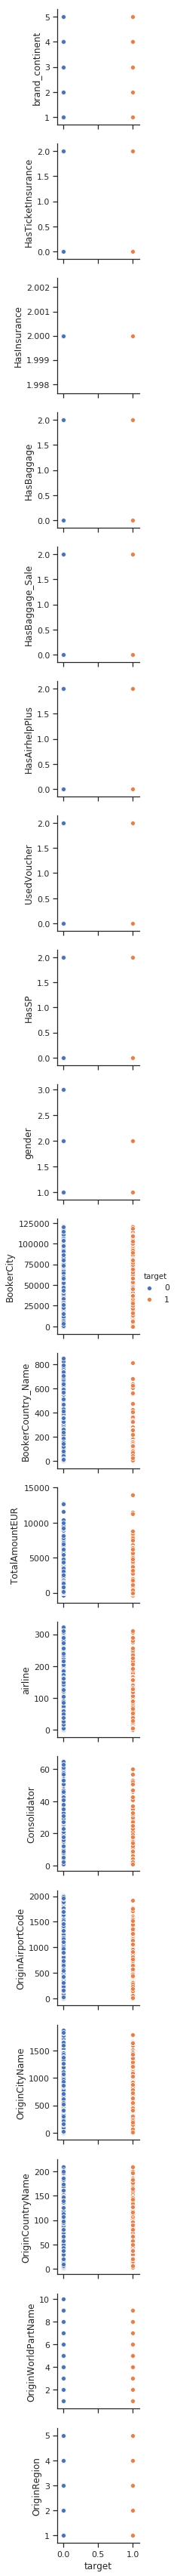

In [71]:
sns.pairplot(X, hue="target", x_vars=['target'],y_vars=['brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion'])

# Random under-sampling

In [31]:
sampler = RandomUnderSampler({1: 2570 , 0: 50000}, random_state=16)

X, y = sampler.fit_sample(df[all_cols], df.target)
X=pd.DataFrame(X, columns=[all_cols])

# GMM sampling

In [16]:
gmm_data=df[all_cols][df.target==0].copy()

scaler = StandardScaler()
gmm_data_arr=scaler.fit_transform(gmm_data)

classifier = GaussianMixture(n_components=5,covariance_type='full', random_state=50,n_init=1, verbose=1,max_iter=100)
classifier.fit(gmm_data_arr)
ll = classifier.score(gmm_data_arr)
print (ll)

gmm_data['cluster']=classifier.predict(gmm_data_arr)
del gmm_data_arr
sampled_good_bookings=stratify_sampling(gmm_data, 50000, 'cluster')

gmm_data=df[all_cols][df.target==1].copy()
gmm_data['target']=1
sampled_good_bookings.drop(['cluster'],axis=1,inplace=True)
sampled_good_bookings['target']=0
sampled_data=gmm_data.append(sampled_good_bookings)

del gmm_data
del sampled_good_bookings

train=sampled_data.iloc[:,:-1]
target=sampled_data.iloc[:,-1]

del sampled_data

train.to_csv('/home/gjain/train.csv')
target.to_csv('/home/gjain/target.csv')

# train=pd.read_csv('/home/gjain/train.csv')
# target=pd.read_csv('/home/gjain/target.csv')

/root/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/root/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# No sampling

In [7]:
y=df.target
X=df[all_cols]

# Train

In [32]:
train=X.as_matrix()
target=np.array(y)

test=pd.read_pickle('/home/gjain/test_data.pkl')

X_test=test[all_cols].as_matrix()
y_test=np.array(test.target)

print (X.shape)
print (X_test.shape)

/home/ubuntu/yes/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/ubuntu/yes/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(52570, 76)
(267688, 76)


In [33]:
from sklearn.decomposition import PCA, KernelPCA
pca=PCA(n_components=2, random_state=26)
pca_out=pca.fit_transform(X)

print(pca.explained_variance_ratio_)  

[0.94381501 0.05392408]


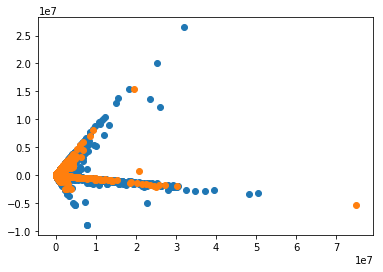

In [34]:
pca_test=pca.transform(X_test)
# pca_out=pca.transform(df[all_cols])
plt.scatter(pca_test[:,0],pca_test[:,1])
# plt.scatter(pca_out[:,0],pca_out[:,1],c=df.target,camp=blue)

pca_test=pca.transform(X)
# pca_out=pca.transform(df[all_cols])
plt.scatter(pca_test[:,0],pca_test[:,1])
# plt.scatter(pca_out[:,0],pca_out[:,1],c=df.target,camp=blue)



In [35]:
space ={
        'max_depth': hp.choice('max_depth',range(3,10)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': 4000, #to be decided by early stopping
        'subsample': hp.uniform('subsample', 0.3, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'min_child_samples': hp.choice('min_child_samples',range(5,2000)),
        'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 15, 700, 1)
       }

#     'class_weight': hp.choice('class_weight', [None, 'balanced']),  

def get_lgb_params(space):
    lgb_params = dict()
    lgb_params['boosting_type'] = 'gbdt'
    lgb_params['objective'] = 'binary'
    lgb_params['max_depth'] = -1
    lgb_params['learning_rate'] = space['learning_rate']
    lgb_params['n_estimators'] = space['n_estimators']
    lgb_params['subsample'] = space['subsample']
#     lgb_params['class_weight'] = {0:1, 1:18}
    lgb_params['colsample_bytree'] = space['colsample_bytree']
    lgb_params['reg_alpha'] = space['reg_alpha'] 
    lgb_params['reg_lambda'] = space['reg_lambda'] 
    lgb_params['random_state'] = 33
    lgb_params['min_child_samples'] = space['min_child_samples']
    lgb_params['importance_type'] = 'gain'
    lgb_params['num_leaves'] = int(space['num_leaves'])
    lgb_params['scale_pos_weight'] = int(space['scale_pos_weight'])    
    return lgb_params


def acc_model(space):
    
    params=get_lgb_params(space)
    
    clf = LGBMClassifier(**params)
    
    fit_params={'eval_set':[(X_test,y_test)],
            'eval_metric':'f1_score', 
            'early_stopping_rounds':40,
            'verbose':True,
            'categorical_feature':categorical_features_pos}
    
    return cross_val_score(clf, train, target, scoring='f1', cv=5, fit_params=fit_params).mean()

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)


  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.310776               
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.414955               
[3]	valid_0's binary_logloss: 0.502909               
[4]	valid_0's binary_logloss: 0.458184               
[5]	valid_0's binary_logloss: 0.417383               
[6]	valid_0's binary_logloss: 0.380182               
[7]	valid_0's binary_logloss: 0.346281               
[8]	valid_0's binary_logloss: 0.392919               
[9]	valid_0's binary_logloss: 0.358146               
[10]	valid_0's binary_logloss: 0.326431              
[11]	valid_0's binary_logloss: 0.297522              
[12]	valid_0's binary_logloss: 0.271185              
[13]	valid_0's binary_logloss: 0.2472                
[14]	valid_0's binary_logloss: 0.273563              
[15]	valid_0's binary_logloss: 0.249573              
[16]	valid_0's binary_logloss: 0.227713              
[17]	valid_0's binary_logloss: 0.207775              
[18]	valid_0's binar

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.30079                
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.397934               
[3]	valid_0's binary_logloss: 0.496796               
[4]	valid_0's binary_logloss: 0.453262               
[5]	valid_0's binary_logloss: 0.413385               
[6]	valid_0's binary_logloss: 0.373784               
[7]	valid_0's binary_logloss: 0.338938               
[8]	valid_0's binary_logloss: 0.386637               
[9]	valid_0's binary_logloss: 0.351447               
[10]	valid_0's binary_logloss: 0.319515              
[11]	valid_0's binary_logloss: 0.290542              
[12]	valid_0's binary_logloss: 0.264255              
[13]	valid_0's binary_logloss: 0.240406              
[14]	valid_0's binary_logloss: 0.265207              
[15]	valid_0's binary_logloss: 0.241573              
[16]	valid_0's binary_logloss: 0.220092              
[17]	valid_0's binary_logloss: 0.200573              
[18]	valid_0's binar

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.303708               
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.345972               
[3]	valid_0's binary_logloss: 0.435691               
[4]	valid_0's binary_logloss: 0.396955               
[5]	valid_0's binary_logloss: 0.35994                
[6]	valid_0's binary_logloss: 0.326474               
[7]	valid_0's binary_logloss: 0.296211               
[8]	valid_0's binary_logloss: 0.337865               
[9]	valid_0's binary_logloss: 0.307126               
[10]	valid_0's binary_logloss: 0.279232              
[11]	valid_0's binary_logloss: 0.253925              
[12]	valid_0's binary_logloss: 0.230967              
[13]	valid_0's binary_logloss: 0.210143              
[14]	valid_0's binary_logloss: 0.233063              
[15]	valid_0's binary_logloss: 0.212274              
[16]	valid_0's binary_logloss: 0.19339               
[17]	valid_0's binary_logloss: 0.17624               
[18]	valid_0's binar

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.309923               
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.397019               
[3]	valid_0's binary_logloss: 0.492808               
[4]	valid_0's binary_logloss: 0.451559               
[5]	valid_0's binary_logloss: 0.411362               
[6]	valid_0's binary_logloss: 0.374709               
[7]	valid_0's binary_logloss: 0.341305               
[8]	valid_0's binary_logloss: 0.389038               
[9]	valid_0's binary_logloss: 0.354573               
[10]	valid_0's binary_logloss: 0.323147              
[11]	valid_0's binary_logloss: 0.294509              
[12]	valid_0's binary_logloss: 0.268424              
[13]	valid_0's binary_logloss: 0.244675              
[14]	valid_0's binary_logloss: 0.270351              
[15]	valid_0's binary_logloss: 0.246637              
[16]	valid_0's binary_logloss: 0.225035              
[17]	valid_0's binary_logloss: 0.205356              
[18]	valid_0's binar

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.310125               
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.417053               
[3]	valid_0's binary_logloss: 0.5195                 
[4]	valid_0's binary_logloss: 0.474018               
[5]	valid_0's binary_logloss: 0.432411               
[6]	valid_0's binary_logloss: 0.394376               
[7]	valid_0's binary_logloss: 0.359631               
[8]	valid_0's binary_logloss: 0.409185               
[9]	valid_0's binary_logloss: 0.373399               
[10]	valid_0's binary_logloss: 0.34069               
[11]	valid_0's binary_logloss: 0.310816              
[12]	valid_0's binary_logloss: 0.283549              
[13]	valid_0's binary_logloss: 0.258677              
[14]	valid_0's binary_logloss: 0.285604              
[15]	valid_0's binary_logloss: 0.260686              
[16]	valid_0's binary_logloss: 0.237956              
[17]	valid_0's binary_logloss: 0.21722               
[18]	valid_0's binar

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.229191                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.209061                                            
[3]	valid_0's binary_logloss: 0.190422                                            
[4]	valid_0's binary_logloss: 0.234438                                            
[5]	valid_0's binary_logloss: 0.213662                                            
[6]	valid_0's binary_logloss: 0.19483                                             
[7]	valid_0's binary_logloss: 0.224816                                            
[8]	valid_0's binary_logloss: 0.20532                                             
[9]	valid_0's binary_logloss: 0.187592                                            
[10]	valid_0's binary_logloss: 0.171468                                           
[11]	valid_0's binary_logloss: 0.192164                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.27137                                             
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.248296                                            
[3]	valid_0's binary_logloss: 0.227175                                            
[4]	valid_0's binary_logloss: 0.261865                                            
[5]	valid_0's binary_logloss: 0.23834                                             
[6]	valid_0's binary_logloss: 0.217541                                            
[7]	valid_0's binary_logloss: 0.251507                                            
[8]	valid_0's binary_logloss: 0.22997                                             
[9]	valid_0's binary_logloss: 0.21034                                             
[10]	valid_0's binary_logloss: 0.192448                                           
[11]	valid_0's binary_logloss: 0.215518                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.267537                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.244429                                            
[3]	valid_0's binary_logloss: 0.223336                                            
[4]	valid_0's binary_logloss: 0.272989                                            
[5]	valid_0's binary_logloss: 0.248547                                            
[6]	valid_0's binary_logloss: 0.226921                                            
[7]	valid_0's binary_logloss: 0.261799                                            
[8]	valid_0's binary_logloss: 0.23934                                             
[9]	valid_0's binary_logloss: 0.218875                                            
[10]	valid_0's binary_logloss: 0.200224                                           
[11]	valid_0's binary_logloss: 0.223043                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.275959                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.252598                                            
[3]	valid_0's binary_logloss: 0.231248                                            
[4]	valid_0's binary_logloss: 0.283135                                            
[5]	valid_0's binary_logloss: 0.259459                                            
[6]	valid_0's binary_logloss: 0.237782                                            
[7]	valid_0's binary_logloss: 0.271104                                            
[8]	valid_0's binary_logloss: 0.248565                                            
[9]	valid_0's binary_logloss: 0.22792                                             
[10]	valid_0's binary_logloss: 0.209015                                           
[11]	valid_0's binary_logloss: 0.234337                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.278117                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.254469                                            
[3]	valid_0's binary_logloss: 0.232872                                            
[4]	valid_0's binary_logloss: 0.284188                                            
[5]	valid_0's binary_logloss: 0.260291                                            
[6]	valid_0's binary_logloss: 0.23843                                             
[7]	valid_0's binary_logloss: 0.275064                                            
[8]	valid_0's binary_logloss: 0.252115                                            
[9]	valid_0's binary_logloss: 0.231103                                            
[10]	valid_0's binary_logloss: 0.211871                                           
[11]	valid_0's binary_logloss: 0.236839                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0520097                                          
Training until validation scores don't improve for 40 rounds.                    
[2]	valid_0's binary_logloss: 0.0629836                                          
[3]	valid_0's binary_logloss: 0.0620614                                          
[4]	valid_0's binary_logloss: 0.0611544                                          
[5]	valid_0's binary_logloss: 0.0602623                                          
[6]	valid_0's binary_logloss: 0.0593848                                          
[7]	valid_0's binary_logloss: 0.0585216                                          
[8]	valid_0's binary_logloss: 0.0576725                                          
[9]	valid_0's binary_logloss: 0.0568373                                          
[10]	valid_0's binary_logloss: 0.0560158                                         
[11]	valid_0's binary_logloss: 0.0552077                                         
[12]	valid_0's b

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0520097                                          
Training until validation scores don't improve for 40 rounds.                    
[2]	valid_0's binary_logloss: 0.0633391                                          
[3]	valid_0's binary_logloss: 0.0624118                                          
[4]	valid_0's binary_logloss: 0.0614996                                          
[5]	valid_0's binary_logloss: 0.0606023                                          
[6]	valid_0's binary_logloss: 0.0597197                                          
[7]	valid_0's binary_logloss: 0.0588515                                          
[8]	valid_0's binary_logloss: 0.0579975                                          
[9]	valid_0's binary_logloss: 0.0571575                                          
[10]	valid_0's binary_logloss: 0.0563312                                         
[11]	valid_0's binary_logloss: 0.0555184                                         
[12]	valid_0's b

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0520098                                          
Training until validation scores don't improve for 40 rounds.                    
[2]	valid_0's binary_logloss: 0.0644323                                          
[3]	valid_0's binary_logloss: 0.0634891                                          
[4]	valid_0's binary_logloss: 0.0625612                                          
[5]	valid_0's binary_logloss: 0.0616485                                          
[6]	valid_0's binary_logloss: 0.0607507                                          
[7]	valid_0's binary_logloss: 0.0598675                                          
[8]	valid_0's binary_logloss: 0.0589987                                          
[9]	valid_0's binary_logloss: 0.0581441                                          
[10]	valid_0's binary_logloss: 0.0573035                                         
[11]	valid_0's binary_logloss: 0.0564765                                         
[12]	valid_0's b

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0520098                                          
Training until validation scores don't improve for 40 rounds.                    
[2]	valid_0's binary_logloss: 0.0622844                                          
[3]	valid_0's binary_logloss: 0.0613712                                          
[4]	valid_0's binary_logloss: 0.060473                                           
[5]	valid_0's binary_logloss: 0.0595895                                          
[6]	valid_0's binary_logloss: 0.0587205                                          
[7]	valid_0's binary_logloss: 0.0578658                                          
[8]	valid_0's binary_logloss: 0.0570252                                          
[9]	valid_0's binary_logloss: 0.0561982                                          
[10]	valid_0's binary_logloss: 0.0553849                                         
[11]	valid_0's binary_logloss: 0.0545849                                         
[12]	valid_0's b

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0520097                                          
Training until validation scores don't improve for 40 rounds.                    
[2]	valid_0's binary_logloss: 0.0644119                                          
[3]	valid_0's binary_logloss: 0.0634677                                          
[4]	valid_0's binary_logloss: 0.0625389                                          
[5]	valid_0's binary_logloss: 0.0616253                                          
[6]	valid_0's binary_logloss: 0.0607266                                          
[7]	valid_0's binary_logloss: 0.0598427                                          
[8]	valid_0's binary_logloss: 0.0589731                                          
[9]	valid_0's binary_logloss: 0.0581178                                          
[10]	valid_0's binary_logloss: 0.0572764                                         
[11]	valid_0's binary_logloss: 0.0564488                                         
[12]	valid_0's b

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0679629                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0815733                                         
[3]	valid_0's binary_logloss: 0.0804925                                         
[4]	valid_0's binary_logloss: 0.0923839                                         
[5]	valid_0's binary_logloss: 0.10434                                           
[6]	valid_0's binary_logloss: 0.116055                                          
[7]	valid_0's binary_logloss: 0.127829                                          
[8]	valid_0's binary_logloss: 0.126121                                          
[9]	valid_0's binary_logloss: 0.136731                                          
[10]	valid_0's binary_logloss: 0.147197                                         
[11]	valid_0's binary_logloss: 0.145231                                         
[12]	valid_0's binary_loglos

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0679593                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0732226                                         
[3]	valid_0's binary_logloss: 0.0722555                                         
[4]	valid_0's binary_logloss: 0.0799048                                         
[5]	valid_0's binary_logloss: 0.0788454                                         
[6]	valid_0's binary_logloss: 0.0778014                                         
[7]	valid_0's binary_logloss: 0.0855938                                         
[8]	valid_0's binary_logloss: 0.0844578                                         
[9]	valid_0's binary_logloss: 0.091683                                          
[10]	valid_0's binary_logloss: 0.090465                                         
[11]	valid_0's binary_logloss: 0.0970189                                        
[12]	valid_0's binary_loglos

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0679194                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0734396                                         
[3]	valid_0's binary_logloss: 0.0724695                                         
[4]	valid_0's binary_logloss: 0.0811136                                         
[5]	valid_0's binary_logloss: 0.0800375                                         
[6]	valid_0's binary_logloss: 0.0789769                                         
[7]	valid_0's binary_logloss: 0.0869162                                         
[8]	valid_0's binary_logloss: 0.0857624                                         
[9]	valid_0's binary_logloss: 0.0930157                                         
[10]	valid_0's binary_logloss: 0.0917809                                        
[11]	valid_0's binary_logloss: 0.0979515                                        
[12]	valid_0's binary_loglos

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0679641                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0795289                                         
[3]	valid_0's binary_logloss: 0.0784742                                         
[4]	valid_0's binary_logloss: 0.0900927                                         
[5]	valid_0's binary_logloss: 0.101395                                          
[6]	valid_0's binary_logloss: 0.11278                                           
[7]	valid_0's binary_logloss: 0.124139                                          
[8]	valid_0's binary_logloss: 0.122483                                          
[9]	valid_0's binary_logloss: 0.132802                                          
[10]	valid_0's binary_logloss: 0.131261                                         
[11]	valid_0's binary_logloss: 0.129505                                         
[12]	valid_0's binary_loglos

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0681026                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0734237                                         
[3]	valid_0's binary_logloss: 0.0724528                                         
[4]	valid_0's binary_logloss: 0.0828601                                         
[5]	valid_0's binary_logloss: 0.0817588                                         
[6]	valid_0's binary_logloss: 0.0806735                                         
[7]	valid_0's binary_logloss: 0.0888823                                         
[8]	valid_0's binary_logloss: 0.0877025                                         
[9]	valid_0's binary_logloss: 0.0939403                                         
[10]	valid_0's binary_logloss: 0.0926911                                        
[11]	valid_0's binary_logloss: 0.0995272                                        
[12]	valid_0's binary_loglos

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0758117                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0945852                                         
[3]	valid_0's binary_logloss: 0.092765                                          
[4]	valid_0's binary_logloss: 0.0909825                                         
[5]	valid_0's binary_logloss: 0.089237                                          
[6]	valid_0's binary_logloss: 0.0875276                                         
[7]	valid_0's binary_logloss: 0.0858536                                         
[8]	valid_0's binary_logloss: 0.0842143                                         
[9]	valid_0's binary_logloss: 0.0826089                                         
[10]	valid_0's binary_logloss: 0.0810367                                        
[11]	valid_0's binary_logloss: 0.079497                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0760965                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0948217                                         
[3]	valid_0's binary_logloss: 0.092996                                          
[4]	valid_0's binary_logloss: 0.0912082                                         
[5]	valid_0's binary_logloss: 0.0894575                                         
[6]	valid_0's binary_logloss: 0.0877431                                         
[7]	valid_0's binary_logloss: 0.0860641                                         
[8]	valid_0's binary_logloss: 0.08442                                           
[9]	valid_0's binary_logloss: 0.0828098                                         
[10]	valid_0's binary_logloss: 0.081233                                         
[11]	valid_0's binary_logloss: 0.0796888                                        
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.075837                                          
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0968671                                         
[3]	valid_0's binary_logloss: 0.0950041                                         
[4]	valid_0's binary_logloss: 0.0931797                                         
[5]	valid_0's binary_logloss: 0.0913929                                         
[6]	valid_0's binary_logloss: 0.089643                                          
[7]	valid_0's binary_logloss: 0.0879293                                         
[8]	valid_0's binary_logloss: 0.0862509                                         
[9]	valid_0's binary_logloss: 0.0846072                                         
[10]	valid_0's binary_logloss: 0.0829974                                        
[11]	valid_0's binary_logloss: 0.0814208                                        
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0757749                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0972904                                         
[3]	valid_0's binary_logloss: 0.0954203                                         
[4]	valid_0's binary_logloss: 0.0935888                                         
[5]	valid_0's binary_logloss: 0.0917951                                         
[6]	valid_0's binary_logloss: 0.0900384                                         
[7]	valid_0's binary_logloss: 0.0883179                                         
[8]	valid_0's binary_logloss: 0.0866329                                         
[9]	valid_0's binary_logloss: 0.0849826                                         
[10]	valid_0's binary_logloss: 0.0833663                                        
[11]	valid_0's binary_logloss: 0.0817833                                        
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0751417                                         
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.0969486                                         
[3]	valid_0's binary_logloss: 0.095085                                          
[4]	valid_0's binary_logloss: 0.0932599                                         
[5]	valid_0's binary_logloss: 0.0914724                                         
[6]	valid_0's binary_logloss: 0.0897219                                         
[7]	valid_0's binary_logloss: 0.0880074                                         
[8]	valid_0's binary_logloss: 0.0863283                                         
[9]	valid_0's binary_logloss: 0.0846838                                         
[10]	valid_0's binary_logloss: 0.0830732                                        
[11]	valid_0's binary_logloss: 0.0814958                                        
[12]	valid_0's binary_loglos

  5%|▌         | 5/100 [07:48<2:24:25, 91.22s/it, best loss: -0.288697883730004]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.435534                                          
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.388773                                          
[3]	valid_0's binary_logloss: 0.346984                                          
[4]	valid_0's binary_logloss: 0.413547                                          
[5]	valid_0's binary_logloss: 0.481943                                          
[6]	valid_0's binary_logloss: 0.559269                                          
[7]	valid_0's binary_logloss: 0.626514                                          
[8]	valid_0's binary_logloss: 0.701464                                          
[9]	valid_0's binary_logloss: 0.631767                                          
[10]	valid_0's binary_logloss: 0.568407                                         
[11]	valid_0's binary_logloss: 0.510945                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.44074                                           
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.393718                                          
[3]	valid_0's binary_logloss: 0.351656                                          
[4]	valid_0's binary_logloss: 0.419807                                          
[5]	valid_0's binary_logloss: 0.468472                                          
[6]	valid_0's binary_logloss: 0.542082                                          
[7]	valid_0's binary_logloss: 0.588857                                          
[8]	valid_0's binary_logloss: 0.659332                                          
[9]	valid_0's binary_logloss: 0.593334                                          
[10]	valid_0's binary_logloss: 0.53335                                          
[11]	valid_0's binary_logloss: 0.478978                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.441758                                          
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.393764                                          
[3]	valid_0's binary_logloss: 0.350992                                          
[4]	valid_0's binary_logloss: 0.42369                                           
[5]	valid_0's binary_logloss: 0.484834                                          
[6]	valid_0's binary_logloss: 0.561329                                          
[7]	valid_0's binary_logloss: 0.632249                                          
[8]	valid_0's binary_logloss: 0.70768                                           
[9]	valid_0's binary_logloss: 0.638401                                          
[10]	valid_0's binary_logloss: 0.575218                                         
[11]	valid_0's binary_logloss: 0.517748                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.43753                                           
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.390514                                          
[3]	valid_0's binary_logloss: 0.348512                                          
[4]	valid_0's binary_logloss: 0.416963                                          
[5]	valid_0's binary_logloss: 0.483811                                          
[6]	valid_0's binary_logloss: 0.556565                                          
[7]	valid_0's binary_logloss: 0.625664                                          
[8]	valid_0's binary_logloss: 0.697367                                          
[9]	valid_0's binary_logloss: 0.628555                                          
[10]	valid_0's binary_logloss: 0.565883                                         
[11]	valid_0's binary_logloss: 0.508953                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.441455                                          
Training until validation scores don't improve for 40 rounds.                   
[2]	valid_0's binary_logloss: 0.393235                                          
[3]	valid_0's binary_logloss: 0.350313                                          
[4]	valid_0's binary_logloss: 0.418445                                          
[5]	valid_0's binary_logloss: 0.480837                                          
[6]	valid_0's binary_logloss: 0.556249                                          
[7]	valid_0's binary_logloss: 0.615865                                          
[8]	valid_0's binary_logloss: 0.687511                                          
[9]	valid_0's binary_logloss: 0.618643                                          
[10]	valid_0's binary_logloss: 0.556108                                         
[11]	valid_0's binary_logloss: 0.499462                                         
[12]	valid_0's binary_loglos

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0642187                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0627057                                           
[3]	valid_0's binary_logloss: 0.0612326                                           
[4]	valid_0's binary_logloss: 0.0597983                                           
[5]	valid_0's binary_logloss: 0.0584017                                           
[6]	valid_0's binary_logloss: 0.0570418                                           
[7]	valid_0's binary_logloss: 0.0557177                                           
[8]	valid_0's binary_logloss: 0.0544283                                           
[9]	valid_0's binary_logloss: 0.0597194                                           
[10]	valid_0's binary_logloss: 0.0583348                                          
[11]	valid_0's binary_logloss: 0.0569862                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0641107                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0626006                                           
[3]	valid_0's binary_logloss: 0.0611302                                           
[4]	valid_0's binary_logloss: 0.0596986                                           
[5]	valid_0's binary_logloss: 0.0583046                                           
[6]	valid_0's binary_logloss: 0.0569472                                           
[7]	valid_0's binary_logloss: 0.0556255                                           
[8]	valid_0's binary_logloss: 0.0543385                                           
[9]	valid_0's binary_logloss: 0.0597846                                           
[10]	valid_0's binary_logloss: 0.0583992                                          
[11]	valid_0's binary_logloss: 0.0570497                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0644206                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0629015                                           
[3]	valid_0's binary_logloss: 0.0614225                                           
[4]	valid_0's binary_logloss: 0.0599825                                           
[5]	valid_0's binary_logloss: 0.0585804                                           
[6]	valid_0's binary_logloss: 0.0572152                                           
[7]	valid_0's binary_logloss: 0.0558858                                           
[8]	valid_0's binary_logloss: 0.0545914                                           
[9]	valid_0's binary_logloss: 0.0599313                                           
[10]	valid_0's binary_logloss: 0.0585395                                          
[11]	valid_0's binary_logloss: 0.057184                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0523883                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0511685                                           
[3]	valid_0's binary_logloss: 0.0499813                                           
[4]	valid_0's binary_logloss: 0.0488258                                           
[5]	valid_0's binary_logloss: 0.047701                                            
[6]	valid_0's binary_logloss: 0.0466062                                           
[7]	valid_0's binary_logloss: 0.0455404                                           
[8]	valid_0's binary_logloss: 0.0445031                                           
[9]	valid_0's binary_logloss: 0.0437494                                           
[10]	valid_0's binary_logloss: 0.0427587                                          
[11]	valid_0's binary_logloss: 0.0417943                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0639853                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0624779                                           
[3]	valid_0's binary_logloss: 0.0610102                                           
[4]	valid_0's binary_logloss: 0.0595812                                           
[5]	valid_0's binary_logloss: 0.0581897                                           
[6]	valid_0's binary_logloss: 0.0568349                                           
[7]	valid_0's binary_logloss: 0.0555157                                           
[8]	valid_0's binary_logloss: 0.054231                                            
[9]	valid_0's binary_logloss: 0.0595763                                           
[10]	valid_0's binary_logloss: 0.0581948                                          
[11]	valid_0's binary_logloss: 0.0568493                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.166345                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.225254                                             
[3]	valid_0's binary_logloss: 0.290234                                             
[4]	valid_0's binary_logloss: 0.273133                                             
[5]	valid_0's binary_logloss: 0.257042                                             
[6]	valid_0's binary_logloss: 0.241902                                             
[7]	valid_0's binary_logloss: 0.227661                                             
[8]	valid_0's binary_logloss: 0.25655                                              
[9]	valid_0's binary_logloss: 0.241507                                             
[10]	valid_0's binary_logloss: 0.227351                                            
[11]	valid_0's binary_logloss: 0.214032                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.167645                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.230342                                             
[3]	valid_0's binary_logloss: 0.29502                                              
[4]	valid_0's binary_logloss: 0.277705                                             
[5]	valid_0's binary_logloss: 0.261404                                             
[6]	valid_0's binary_logloss: 0.246061                                             
[7]	valid_0's binary_logloss: 0.231622                                             
[8]	valid_0's binary_logloss: 0.258254                                             
[9]	valid_0's binary_logloss: 0.243211                                             
[10]	valid_0's binary_logloss: 0.229045                                            
[11]	valid_0's binary_logloss: 0.215709                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.1668                                               
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.237868                                             
[3]	valid_0's binary_logloss: 0.286962                                             
[4]	valid_0's binary_logloss: 0.270146                                             
[5]	valid_0's binary_logloss: 0.254314                                             
[6]	valid_0's binary_logloss: 0.239411                                             
[7]	valid_0's binary_logloss: 0.225386                                             
[8]	valid_0's binary_logloss: 0.254081                                             
[9]	valid_0's binary_logloss: 0.239265                                             
[10]	valid_0's binary_logloss: 0.225316                                            
[11]	valid_0's binary_logloss: 0.212186                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.165712                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.22621                                              
[3]	valid_0's binary_logloss: 0.293317                                             
[4]	valid_0's binary_logloss: 0.27603                                              
[5]	valid_0's binary_logloss: 0.259764                                             
[6]	valid_0's binary_logloss: 0.24446                                              
[7]	valid_0's binary_logloss: 0.230065                                             
[8]	valid_0's binary_logloss: 0.261043                                             
[9]	valid_0's binary_logloss: 0.245809                                             
[10]	valid_0's binary_logloss: 0.231466                                            
[11]	valid_0's binary_logloss: 0.217965                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.162087                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.233168                                             
[3]	valid_0's binary_logloss: 0.29766                                              
[4]	valid_0's binary_logloss: 0.280141                                             
[5]	valid_0's binary_logloss: 0.263654                                             
[6]	valid_0's binary_logloss: 0.248141                                             
[7]	valid_0's binary_logloss: 0.233546                                             
[8]	valid_0's binary_logloss: 0.264389                                             
[9]	valid_0's binary_logloss: 0.248972                                             
[10]	valid_0's binary_logloss: 0.234455                                            
[11]	valid_0's binary_logloss: 0.220789                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.162059                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.214288                                            
[3]	valid_0's binary_logloss: 0.188759                                            
[4]	valid_0's binary_logloss: 0.165851                                            
[5]	valid_0's binary_logloss: 0.19918                                             
[6]	valid_0's binary_logloss: 0.173267                                            
[7]	valid_0's binary_logloss: 0.202149                                            
[8]	valid_0's binary_logloss: 0.178506                                            
[9]	valid_0's binary_logloss: 0.205262                                            
[10]	valid_0's binary_logloss: 0.233067                                           
[11]	valid_0's binary_logloss: 0.205069                                           
[12]

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.462345                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.596121                                            
[3]	valid_0's binary_logloss: 0.531758                                            
[4]	valid_0's binary_logloss: 0.472255                                            
[5]	valid_0's binary_logloss: 0.47963                                             
[6]	valid_0's binary_logloss: 0.41871                                             
[7]	valid_0's binary_logloss: 0.482683                                            
[8]	valid_0's binary_logloss: 0.429809                                            
[9]	valid_0's binary_logloss: 0.487556                                            
[10]	valid_0's binary_logloss: 0.548258                                           
[11]	valid_0's binary_logloss: 0.487978                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.466799                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.599338                                            
[3]	valid_0's binary_logloss: 0.538925                                            
[4]	valid_0's binary_logloss: 0.484003                                            
[5]	valid_0's binary_logloss: 0.505307                                            
[6]	valid_0's binary_logloss: 0.44746                                             
[7]	valid_0's binary_logloss: 0.513544                                            
[8]	valid_0's binary_logloss: 0.461253                                            
[9]	valid_0's binary_logloss: 0.52291                                             
[10]	valid_0's binary_logloss: 0.584923                                           
[11]	valid_0's binary_logloss: 0.524605                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0586781                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0774151                                           
[3]	valid_0's binary_logloss: 0.0681571                                           
[4]	valid_0's binary_logloss: 0.060017                                            
[5]	valid_0's binary_logloss: 0.0570077                                           
[6]	valid_0's binary_logloss: 0.0498035                                           
[7]	valid_0's binary_logloss: 0.0579096                                           
[8]	valid_0's binary_logloss: 0.0513545                                           
[9]	valid_0's binary_logloss: 0.0588233                                           
[10]	valid_0's binary_logloss: 0.0668004                                          
[11]	valid_0's binary_logloss: 0.0589554                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.461842                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.594629                                            
[3]	valid_0's binary_logloss: 0.533657                                            
[4]	valid_0's binary_logloss: 0.478237                                            
[5]	valid_0's binary_logloss: 0.489419                                            
[6]	valid_0's binary_logloss: 0.436367                                            
[7]	valid_0's binary_logloss: 0.499661                                            
[8]	valid_0's binary_logloss: 0.447642                                            
[9]	valid_0's binary_logloss: 0.505868                                            
[10]	valid_0's binary_logloss: 0.566624                                           
[11]	valid_0's binary_logloss: 0.507909                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.100043                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.142048                                            
[3]	valid_0's binary_logloss: 0.181314                                            
[4]	valid_0's binary_logloss: 0.17444                                             
[5]	valid_0's binary_logloss: 0.167837                                            
[6]	valid_0's binary_logloss: 0.161495                                            
[7]	valid_0's binary_logloss: 0.155404                                            
[8]	valid_0's binary_logloss: 0.174424                                            
[9]	valid_0's binary_logloss: 0.167855                                            
[10]	valid_0's binary_logloss: 0.161544                                           
[11]	valid_0's binary_logloss: 0.155481                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.101945                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.144904                                            
[3]	valid_0's binary_logloss: 0.184862                                            
[4]	valid_0's binary_logloss: 0.177894                                            
[5]	valid_0's binary_logloss: 0.171199                                            
[6]	valid_0's binary_logloss: 0.164766                                            
[7]	valid_0's binary_logloss: 0.158584                                            
[8]	valid_0's binary_logloss: 0.177692                                            
[9]	valid_0's binary_logloss: 0.171036                                            
[10]	valid_0's binary_logloss: 0.16464                                            
[11]	valid_0's binary_logloss: 0.158491                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.10658                                             
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.150951                                            
[3]	valid_0's binary_logloss: 0.179471                                            
[4]	valid_0's binary_logloss: 0.172738                                            
[5]	valid_0's binary_logloss: 0.166267                                            
[6]	valid_0's binary_logloss: 0.160047                                            
[7]	valid_0's binary_logloss: 0.154069                                            
[8]	valid_0's binary_logloss: 0.172207                                            
[9]	valid_0's binary_logloss: 0.165786                                            
[10]	valid_0's binary_logloss: 0.159614                                           
[11]	valid_0's binary_logloss: 0.15368                                            
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.108531                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.152757                                            
[3]	valid_0's binary_logloss: 0.193345                                            
[4]	valid_0's binary_logloss: 0.186111                                            
[5]	valid_0's binary_logloss: 0.179156                                            
[6]	valid_0's binary_logloss: 0.172469                                            
[7]	valid_0's binary_logloss: 0.16604                                             
[8]	valid_0's binary_logloss: 0.185992                                            
[9]	valid_0's binary_logloss: 0.179069                                            
[10]	valid_0's binary_logloss: 0.172412                                           
[11]	valid_0's binary_logloss: 0.16601                                            
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.108658                                            
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.152943                                            
[3]	valid_0's binary_logloss: 0.191762                                            
[4]	valid_0's binary_logloss: 0.184575                                            
[5]	valid_0's binary_logloss: 0.177665                                            
[6]	valid_0's binary_logloss: 0.171023                                            
[7]	valid_0's binary_logloss: 0.164638                                            
[8]	valid_0's binary_logloss: 0.184089                                            
[9]	valid_0's binary_logloss: 0.177233                                            
[10]	valid_0's binary_logloss: 0.17064                                            
[11]	valid_0's binary_logloss: 0.164301                                           
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.142271                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.134998                                             
[3]	valid_0's binary_logloss: 0.169057                                             
[4]	valid_0's binary_logloss: 0.160479                                             
[5]	valid_0's binary_logloss: 0.191265                                             
[6]	valid_0's binary_logloss: 0.181613                                             
[7]	valid_0's binary_logloss: 0.172457                                             
[8]	valid_0's binary_logloss: 0.193919                                             
[9]	valid_0's binary_logloss: 0.184342                                             
[10]	valid_0's binary_logloss: 0.175043                                            
[11]	valid_0's binary_logloss: 0.192224                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.14272                                              
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.13544                                              
[3]	valid_0's binary_logloss: 0.173937                                             
[4]	valid_0's binary_logloss: 0.165146                                             
[5]	valid_0's binary_logloss: 0.189342                                             
[6]	valid_0's binary_logloss: 0.179807                                             
[7]	valid_0's binary_logloss: 0.17076                                              
[8]	valid_0's binary_logloss: 0.184764                                             
[9]	valid_0's binary_logloss: 0.176289                                             
[10]	valid_0's binary_logloss: 0.167394                                            
[11]	valid_0's binary_logloss: 0.184586                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0717774                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0998546                                            
[3]	valid_0's binary_logloss: 0.0946413                                            
[4]	valid_0's binary_logloss: 0.089723                                             
[5]	valid_0's binary_logloss: 0.0902327                                            
[6]	valid_0's binary_logloss: 0.0855335                                            
[7]	valid_0's binary_logloss: 0.0811019                                            
[8]	valid_0's binary_logloss: 0.0769221                                            
[9]	valid_0's binary_logloss: 0.0863397                                            
[10]	valid_0's binary_logloss: 0.0948993                                           
[11]	valid_0's binary_logloss: 0.0900061                                    

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.143836                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.136474                                             
[3]	valid_0's binary_logloss: 0.154756                                             
[4]	valid_0's binary_logloss: 0.146864                                             
[5]	valid_0's binary_logloss: 0.175188                                             
[6]	valid_0's binary_logloss: 0.166299                                             
[7]	valid_0's binary_logloss: 0.157873                                             
[8]	valid_0's binary_logloss: 0.175424                                             
[9]	valid_0's binary_logloss: 0.165918                                             
[10]	valid_0's binary_logloss: 0.157501                                            
[11]	valid_0's binary_logloss: 0.173386                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.136591                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.18517                                              
[3]	valid_0's binary_logloss: 0.17573                                              
[4]	valid_0's binary_logloss: 0.166782                                             
[5]	valid_0's binary_logloss: 0.165178                                             
[6]	valid_0's binary_logloss: 0.156737                                             
[7]	valid_0's binary_logloss: 0.148741                                             
[8]	valid_0's binary_logloss: 0.141168                                             
[9]	valid_0's binary_logloss: 0.15838                                              
[10]	valid_0's binary_logloss: 0.161768                                            
[11]	valid_0's binary_logloss: 0.153583                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0518684                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0509817                                            
[3]	valid_0's binary_logloss: 0.050137                                             
[4]	valid_0's binary_logloss: 0.0568393                                            
[5]	valid_0's binary_logloss: 0.0558612                                            
[6]	valid_0's binary_logloss: 0.0549023                                            
[7]	valid_0's binary_logloss: 0.0607129                                            
[8]	valid_0's binary_logloss: 0.0596667                                            
[9]	valid_0's binary_logloss: 0.0586408                                            
[10]	valid_0's binary_logloss: 0.0576348                                           
[11]	valid_0's binary_logloss: 0.0566482                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.058623                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.057614                                             
[3]	valid_0's binary_logloss: 0.0566511                                            
[4]	valid_0's binary_logloss: 0.0656849                                            
[5]	valid_0's binary_logloss: 0.0645479                                            
[6]	valid_0's binary_logloss: 0.0634328                                            
[7]	valid_0's binary_logloss: 0.0698251                                            
[8]	valid_0's binary_logloss: 0.068615                                             
[9]	valid_0's binary_logloss: 0.0674281                                            
[10]	valid_0's binary_logloss: 0.066264                                            
[11]	valid_0's binary_logloss: 0.0651222                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0519018                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0510146                                            
[3]	valid_0's binary_logloss: 0.0501706                                            
[4]	valid_0's binary_logloss: 0.0579669                                            
[5]	valid_0's binary_logloss: 0.0569683                                            
[6]	valid_0's binary_logloss: 0.0559893                                            
[7]	valid_0's binary_logloss: 0.0620938                                            
[8]	valid_0's binary_logloss: 0.0610229                                            
[9]	valid_0's binary_logloss: 0.0599726                                            
[10]	valid_0's binary_logloss: 0.0589426                                           
[11]	valid_0's binary_logloss: 0.0579325                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0646697                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0635511                                            
[3]	valid_0's binary_logloss: 0.0624838                                            
[4]	valid_0's binary_logloss: 0.0723592                                            
[5]	valid_0's binary_logloss: 0.0711042                                            
[6]	valid_0's binary_logloss: 0.0698732                                            
[7]	valid_0's binary_logloss: 0.0767169                                            
[8]	valid_0's binary_logloss: 0.0753865                                            
[9]	valid_0's binary_logloss: 0.0740813                                            
[10]	valid_0's binary_logloss: 0.0728009                                           
[11]	valid_0's binary_logloss: 0.0715448                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0710683                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0698362                                            
[3]	valid_0's binary_logloss: 0.0686627                                            
[4]	valid_0's binary_logloss: 0.0800193                                            
[5]	valid_0's binary_logloss: 0.0786283                                            
[6]	valid_0's binary_logloss: 0.0772636                                            
[7]	valid_0's binary_logloss: 0.0857798                                            
[8]	valid_0's binary_logloss: 0.0842898                                            
[9]	valid_0's binary_logloss: 0.0828279                                            
[10]	valid_0's binary_logloss: 0.0813935                                           
[11]	valid_0's binary_logloss: 0.079986                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.147971                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.140251                                             
[3]	valid_0's binary_logloss: 0.181889                                             
[4]	valid_0's binary_logloss: 0.222059                                             
[5]	valid_0's binary_logloss: 0.210464                                             
[6]	valid_0's binary_logloss: 0.19949                                              
[7]	valid_0's binary_logloss: 0.227302                                             
[8]	valid_0's binary_logloss: 0.255259                                             
[9]	valid_0's binary_logloss: 0.24201                                              
[10]	valid_0's binary_logloss: 0.229459                                            
[11]	valid_0's binary_logloss: 0.21757                                      

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.141707                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.134104                                             
[3]	valid_0's binary_logloss: 0.174518                                             
[4]	valid_0's binary_logloss: 0.213489                                             
[5]	valid_0's binary_logloss: 0.202206                                             
[6]	valid_0's binary_logloss: 0.191541                                             
[7]	valid_0's binary_logloss: 0.21914                                              
[8]	valid_0's binary_logloss: 0.247276                                             
[9]	valid_0's binary_logloss: 0.234431                                             
[10]	valid_0's binary_logloss: 0.222265                                            
[11]	valid_0's binary_logloss: 0.210743                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.147766                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.139949                                             
[3]	valid_0's binary_logloss: 0.180995                                             
[4]	valid_0's binary_logloss: 0.217467                                             
[5]	valid_0's binary_logloss: 0.205955                                             
[6]	valid_0's binary_logloss: 0.195074                                             
[7]	valid_0's binary_logloss: 0.223017                                             
[8]	valid_0's binary_logloss: 0.247673                                             
[9]	valid_0's binary_logloss: 0.234744                                             
[10]	valid_0's binary_logloss: 0.222503                                            
[11]	valid_0's binary_logloss: 0.210916                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.147984                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.1402                                               
[3]	valid_0's binary_logloss: 0.181278                                             
[4]	valid_0's binary_logloss: 0.214864                                             
[5]	valid_0's binary_logloss: 0.20354                                              
[6]	valid_0's binary_logloss: 0.192831                                             
[7]	valid_0's binary_logloss: 0.220449                                             
[8]	valid_0's binary_logloss: 0.248956                                             
[9]	valid_0's binary_logloss: 0.236069                                             
[10]	valid_0's binary_logloss: 0.223858                                            
[11]	valid_0's binary_logloss: 0.21229                                      

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.147714                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.139931                                             
[3]	valid_0's binary_logloss: 0.181083                                             
[4]	valid_0's binary_logloss: 0.221812                                             
[5]	valid_0's binary_logloss: 0.210152                                             
[6]	valid_0's binary_logloss: 0.199125                                             
[7]	valid_0's binary_logloss: 0.227147                                             
[8]	valid_0's binary_logloss: 0.255523                                             
[9]	valid_0's binary_logloss: 0.242236                                             
[10]	valid_0's binary_logloss: 0.229651                                            
[11]	valid_0's binary_logloss: 0.217732                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0517112                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.050674                                             
[3]	valid_0's binary_logloss: 0.0496867                                            
[4]	valid_0's binary_logloss: 0.0582151                                            
[5]	valid_0's binary_logloss: 0.0570387                                            
[6]	valid_0's binary_logloss: 0.0558892                                            
[7]	valid_0's binary_logloss: 0.0547658                                            
[8]	valid_0's binary_logloss: 0.0536681                                            
[9]	valid_0's binary_logloss: 0.0525953                                            
[10]	valid_0's binary_logloss: 0.0515469                                           
[11]	valid_0's binary_logloss: 0.0505224                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0589661                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0577744                                            
[3]	valid_0's binary_logloss: 0.0566422                                            
[4]	valid_0's binary_logloss: 0.0657947                                            
[5]	valid_0's binary_logloss: 0.0644576                                            
[6]	valid_0's binary_logloss: 0.0631507                                            
[7]	valid_0's binary_logloss: 0.0618733                                            
[8]	valid_0's binary_logloss: 0.0606248                                            
[9]	valid_0's binary_logloss: 0.0594044                                            
[10]	valid_0's binary_logloss: 0.0582116                                           
[11]	valid_0's binary_logloss: 0.0570457                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.051749                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.050711                                             
[3]	valid_0's binary_logloss: 0.0497245                                            
[4]	valid_0's binary_logloss: 0.0582131                                            
[5]	valid_0's binary_logloss: 0.0570359                                            
[6]	valid_0's binary_logloss: 0.0558856                                            
[7]	valid_0's binary_logloss: 0.0547616                                            
[8]	valid_0's binary_logloss: 0.0536631                                            
[9]	valid_0's binary_logloss: 0.0525897                                            
[10]	valid_0's binary_logloss: 0.0515407                                           
[11]	valid_0's binary_logloss: 0.0505156                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0662089                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0648639                                            
[3]	valid_0's binary_logloss: 0.0635833                                            
[4]	valid_0's binary_logloss: 0.0745721                                            
[5]	valid_0's binary_logloss: 0.073053                                             
[6]	valid_0's binary_logloss: 0.0715679                                            
[7]	valid_0's binary_logloss: 0.070116                                             
[8]	valid_0's binary_logloss: 0.0686965                                            
[9]	valid_0's binary_logloss: 0.0673087                                            
[10]	valid_0's binary_logloss: 0.0659519                                           
[11]	valid_0's binary_logloss: 0.0646253                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0743987                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0728831                                            
[3]	valid_0's binary_logloss: 0.0714417                                            
[4]	valid_0's binary_logloss: 0.0840857                                            
[5]	valid_0's binary_logloss: 0.0823695                                            
[6]	valid_0's binary_logloss: 0.0806912                                            
[7]	valid_0's binary_logloss: 0.07905                                              
[8]	valid_0's binary_logloss: 0.0774452                                            
[9]	valid_0's binary_logloss: 0.0758758                                            
[10]	valid_0's binary_logloss: 0.0743411                                           
[11]	valid_0's binary_logloss: 0.0728403                                    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0867715                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0845648                                            
[3]	valid_0's binary_logloss: 0.104532                                             
[4]	valid_0's binary_logloss: 0.12486                                              
[5]	valid_0's binary_logloss: 0.121641                                             
[6]	valid_0's binary_logloss: 0.11851                                              
[7]	valid_0's binary_logloss: 0.133331                                             
[8]	valid_0's binary_logloss: 0.129893                                             
[9]	valid_0's binary_logloss: 0.126548                                             
[10]	valid_0's binary_logloss: 0.123294                                            
[11]	valid_0's binary_logloss: 0.120129                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0855909                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0833915                                            
[3]	valid_0's binary_logloss: 0.104405                                             
[4]	valid_0's binary_logloss: 0.125076                                             
[5]	valid_0's binary_logloss: 0.121845                                             
[6]	valid_0's binary_logloss: 0.118702                                             
[7]	valid_0's binary_logloss: 0.133716                                             
[8]	valid_0's binary_logloss: 0.130271                                             
[9]	valid_0's binary_logloss: 0.126921                                             
[10]	valid_0's binary_logloss: 0.123661                                            
[11]	valid_0's binary_logloss: 0.120489                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0868275                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0846044                                            
[3]	valid_0's binary_logloss: 0.105671                                             
[4]	valid_0's binary_logloss: 0.124429                                             
[5]	valid_0's binary_logloss: 0.121205                                             
[6]	valid_0's binary_logloss: 0.118069                                             
[7]	valid_0's binary_logloss: 0.132941                                             
[8]	valid_0's binary_logloss: 0.129496                                             
[9]	valid_0's binary_logloss: 0.126146                                             
[10]	valid_0's binary_logloss: 0.122887                                            
[11]	valid_0's binary_logloss: 0.119718                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0828721                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0807392                                            
[3]	valid_0's binary_logloss: 0.101225                                             
[4]	valid_0's binary_logloss: 0.119782                                             
[5]	valid_0's binary_logloss: 0.116664                                             
[6]	valid_0's binary_logloss: 0.113633                                             
[7]	valid_0's binary_logloss: 0.127938                                             
[8]	valid_0's binary_logloss: 0.124614                                             
[9]	valid_0's binary_logloss: 0.121381                                             
[10]	valid_0's binary_logloss: 0.118238                                            
[11]	valid_0's binary_logloss: 0.115181                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0867701                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0845524                                            
[3]	valid_0's binary_logloss: 0.105373                                             
[4]	valid_0's binary_logloss: 0.125943                                             
[5]	valid_0's binary_logloss: 0.122685                                             
[6]	valid_0's binary_logloss: 0.119516                                             
[7]	valid_0's binary_logloss: 0.134046                                             
[8]	valid_0's binary_logloss: 0.13058                                              
[9]	valid_0's binary_logloss: 0.127208                                             
[10]	valid_0's binary_logloss: 0.123929                                            
[11]	valid_0's binary_logloss: 0.120738                                     

/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67

[1]	valid_0's binary_logloss: 0.0460221                                            
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.0394666                                            
[3]	valid_0's binary_logloss: 0.0340276                                            
[4]	valid_0's binary_logloss: 0.0295022                                            
[5]	valid_0's binary_logloss: 0.0255846                                            
[6]	valid_0's binary_logloss: 0.0223595                                            
[7]	valid_0's binary_logloss: 0.0196952                                            
[8]	valid_0's binary_logloss: 0.0174875                                            
[9]	valid_0's binary_logloss: 0.0196416                                            
[10]	valid_0's binary_logloss: 0.0222123                                           
[11]	valid_0's binary_logloss: 0.023251                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.346301                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.301375                                             
[3]	valid_0's binary_logloss: 0.26205                                              
[4]	valid_0's binary_logloss: 0.227709                                             
[5]	valid_0's binary_logloss: 0.196645                                             
[6]	valid_0's binary_logloss: 0.169986                                             
[7]	valid_0's binary_logloss: 0.147118                                             
[8]	valid_0's binary_logloss: 0.127514                                             
[9]	valid_0's binary_logloss: 0.147873                                             
[10]	valid_0's binary_logloss: 0.167152                                            
[11]	valid_0's binary_logloss: 0.186523                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.541025                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.477432                                             
[3]	valid_0's binary_logloss: 0.420447                                             
[4]	valid_0's binary_logloss: 0.369337                                             
[5]	valid_0's binary_logloss: 0.321941                                             
[6]	valid_0's binary_logloss: 0.280547                                             
[7]	valid_0's binary_logloss: 0.244472                                             
[8]	valid_0's binary_logloss: 0.21309                                              
[9]	valid_0's binary_logloss: 0.242049                                             
[10]	valid_0's binary_logloss: 0.276131                                            
[11]	valid_0's binary_logloss: 0.232658                                     

[194]	valid_0's binary_logloss: 0.0082065                                          
[195]	valid_0's binary_logloss: 0.00825633                                         
Early stopping, best iteration is:                                                 
[155]	valid_0's binary_logloss: 0.00746618
 15%|█▌        | 15/100 [23:06<1:48:42, 76.73s/it, best loss: -0.41685818984048806]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.394786                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.341452                                             
[3]	valid_0's binary_logloss: 0.295166                                             
[4]	valid_0's binary_logloss: 0.255086                                             
[5]	valid_0's binary_logloss: 0.219311                                             
[6]	valid_0's binary_logloss: 0.188827                                             
[7]	valid_0's binary_logloss: 0.162836                                             
[8]	valid_0's binary_logloss: 0.140658                                             
[9]	valid_0's binary_logloss: 0.162308                                             
[10]	valid_0's binary_logloss: 0.185758                                            
[11]	valid_0's binary_logloss: 0.209922                                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.550809                                             
Training until validation scores don't improve for 40 rounds.                      
[2]	valid_0's binary_logloss: 0.484339                                             
[3]	valid_0's binary_logloss: 0.425011                                             
[4]	valid_0's binary_logloss: 0.373242                                             
[5]	valid_0's binary_logloss: 0.325705                                             
[6]	valid_0's binary_logloss: 0.284099                                             
[7]	valid_0's binary_logloss: 0.247779                                             
[8]	valid_0's binary_logloss: 0.287221                                             
[9]	valid_0's binary_logloss: 0.325719                                             
[10]	valid_0's binary_logloss: 0.337823                                            
[11]	valid_0's binary_logloss: 0.374399                                     

[194]	valid_0's binary_logloss: 0.00758732                                         
[195]	valid_0's binary_logloss: 0.00763167                                         
[196]	valid_0's binary_logloss: 0.00769005                                         
[197]	valid_0's binary_logloss: 0.00768695                                         
[198]	valid_0's binary_logloss: 0.00762985                                         
[199]	valid_0's binary_logloss: 0.00762079                                         
[200]	valid_0's binary_logloss: 0.00764359                                         
[201]	valid_0's binary_logloss: 0.00763611                                         
[202]	valid_0's binary_logloss: 0.00763818                                         
[203]	valid_0's binary_logloss: 0.00762259                                         
[204]	valid_0's binary_logloss: 0.00758514                                         
[205]	valid_0's binary_logloss: 0.0075492                                   

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0624441                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0618478                                           
[3]	valid_0's binary_logloss: 0.0612579                                           
[4]	valid_0's binary_logloss: 0.0606742                                           
[5]	valid_0's binary_logloss: 0.0600969                                           
[6]	valid_0's binary_logloss: 0.0595256                                           
[7]	valid_0's binary_logloss: 0.0589605                                           
[8]	valid_0's binary_logloss: 0.0584014                                           
[9]	valid_0's binary_logloss: 0.0578483                                           
[10]	valid_0's binary_logloss: 0.0573011                                          
[11]	valid_0's binary_logloss: 0.0567597                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0607759                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0601968                                           
[3]	valid_0's binary_logloss: 0.0596239                                           
[4]	valid_0's binary_logloss: 0.0590571                                           
[5]	valid_0's binary_logloss: 0.0584964                                           
[6]	valid_0's binary_logloss: 0.0579417                                           
[7]	valid_0's binary_logloss: 0.0573929                                           
[8]	valid_0's binary_logloss: 0.05685                                             
[9]	valid_0's binary_logloss: 0.0563128                                           
[10]	valid_0's binary_logloss: 0.0557814                                          
[11]	valid_0's binary_logloss: 0.0552557                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0635069                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0629009                                           
[3]	valid_0's binary_logloss: 0.0623014                                           
[4]	valid_0's binary_logloss: 0.0617083                                           
[5]	valid_0's binary_logloss: 0.0611215                                           
[6]	valid_0's binary_logloss: 0.060541                                            
[7]	valid_0's binary_logloss: 0.0599666                                           
[8]	valid_0's binary_logloss: 0.0593983                                           
[9]	valid_0's binary_logloss: 0.0588361                                           
[10]	valid_0's binary_logloss: 0.0582798                                          
[11]	valid_0's binary_logloss: 0.0577295                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0634452                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0628401                                           
[3]	valid_0's binary_logloss: 0.0622413                                           
[4]	valid_0's binary_logloss: 0.061649                                            
[5]	valid_0's binary_logloss: 0.0610629                                           
[6]	valid_0's binary_logloss: 0.0604831                                           
[7]	valid_0's binary_logloss: 0.0599094                                           
[8]	valid_0's binary_logloss: 0.0593419                                           
[9]	valid_0's binary_logloss: 0.0587804                                           
[10]	valid_0's binary_logloss: 0.0582248                                          
[11]	valid_0's binary_logloss: 0.0576752                                          
[12]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.0634769                                           
Training until validation scores don't improve for 40 rounds.                     
[2]	valid_0's binary_logloss: 0.0628712                                           
[3]	valid_0's binary_logloss: 0.0622721                                           
[4]	valid_0's binary_logloss: 0.0616793                                           
[5]	valid_0's binary_logloss: 0.0610928                                           
[6]	valid_0's binary_logloss: 0.0605126                                           
[7]	valid_0's binary_logloss: 0.0599386                                           
[8]	valid_0's binary_logloss: 0.0593706                                           
[9]	valid_0's binary_logloss: 0.0588087                                           
[10]	valid_0's binary_logloss: 0.0582527                                          
[11]	valid_0's binary_logloss: 0.0577027                                          
[12]

KeyboardInterrupt: 

In [36]:
??LGBMClassifier

In [18]:
base_params = {
    'n_estimators' : 800,
    'objective': 'binary',
    'random_state': 88,
    'importance_type':'gain'
}

params = {**best, **base_params}
params

{'colsample_bytree': 0.6953593339806226,
 'importance_type': 'gain',
 'learning_rate': 0.08607347428577267,
 'max_depth': 3,
 'min_child_samples': 2,
 'n_estimators': 800,
 'num_leaves': 142,
 'objective': 'binary',
 'random_state': 88,
 'reg_alpha': 0.4660111222407081,
 'reg_lambda': 0.7848274807080052,
 'scale_pos_weight': 20.0,
 'subsample': 0.4851167898103236}

In [52]:
logregobj <- function(preds, dtrain) {
labels <- getinfo(dtrain, “label”)
preds <- 1/(1 + exp(-preds))
grad <- preds - labels
hess <- preds * (1 - preds)
return(list(grad = grad, hess = hess))
}

In [58]:
f1

NameError: name 'f1' is not defined

In [61]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', -f1_score(y_true, y_hat, average='binary'), True

evals_result = {}

# def lgb_f1_score(preds,dtrain):
#     label=dtrain.get_label()
#     preds = 1.0/(1.0+np.exp(-preds))
#     pred = [int(i >= 0.5) for i in preds]
#     tp = sum([int(i == 1 and j == 1) for i,j in zip(pred,label)])
#     precision=float(tp)/sum(pred)
#     recall=float(tp)/sum(label)
#     return 2 * ( precision*recall/(precision+recall) )

params={'colsample_bytree': 0.6953593339806226,
 'importance_type': 'gain',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_samples': 20,
#  'n_estimators': 800,
 'num_leaves': 142,
 'objective': 'binary',
 'random_state': 88,
 'reg_alpha': 0.4660111222407081,
 'reg_lambda': 0.7848274807080052,
 'scale_pos_weight': 20.0,
 'subsample': 0.4851167898103236
 }

train_data=lgb.Dataset(train, target, categorical_feature=categorical_features_pos)
test_data=lgb.Dataset(X_test, y_test, categorical_feature=categorical_features_pos)

model = lgb.train(params,
                 train_data,
                 num_boost_round=5000,
                 valid_sets=[test_data,train_data],
                  valid_names = ['eval', 'train'],
                 early_stopping_rounds= 25,
                 verbose_eval= 4,
                 feval=lgb_f1_score
                 )

# model=model.fit(train, target, eval_set=[(X_test,y_test)], eval_metric='f1_score', early_stopping_rounds=40,
#                 verbose=True, categorical_feature=categorical_features_pos)

# model=model.fit(train, target, 
#                 verbose=True, categorical_feature=categorical_features_pos)
                  

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 25 rounds.


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[4]	train's binary_logloss: 0.17918	train's f1: -0	eval's binary_logloss: 0.0701609	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[8]	train's binary_logloss: 0.171929	train's f1: -0	eval's binary_logloss: 0.0740427	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[12]	train's binary_logloss: 0.167085	train's f1: -0	eval's binary_logloss: 0.0907915	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[16]	train's binary_logloss: 0.164331	train's f1: -0	eval's binary_logloss: 0.101165	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[20]	train's binary_logloss: 0.163011	train's f1: -0	eval's binary_logloss: 0.112116	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarn

[24]	train's binary_logloss: 0.16269	train's f1: -0	eval's binary_logloss: 0.116647	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Early stopping, best iteration is:
[1]	train's binary_logloss: 0.189557	train's f1: -0	eval's binary_logloss: 0.0587979	eval's f1: -0


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
predictions=pd.DataFrame(model.predict_proba(X_test))
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.88 else 0 )

print(f1_score(y_true=y_test, y_pred=y_pred, average=None))
print(precision_score(y_true=y_test, y_pred=y_pred, average=None))
print(recall_score(y_true=y_test, y_pred=y_pred, average=None))

[0.99847659 0.        ]
[0.99695781 0.        ]
[1. 0.]


/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
predictions.iloc[:,1].max()

0.04388380687809239

In [125]:
pd.Series(y_pred).value_counts()

0    267688
Name: 1, dtype: int64

In [45]:
predictions=pd.DataFrame(model.predict_proba(train))
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.88 else 0 )

print(f1_score(y_true=target, y_pred=y_pred, average=None))
print(precision_score(y_true=target, y_pred=y_pred, average=None))
print(recall_score(y_true=target, y_pred=y_pred, average=None))

[0.99950004 0.98727088]
[0.99942009 0.98928571]
[0.99958    0.98526423]


In [76]:
from sklearn.externals import joblib
joblib.dump(model, '/home/gjain/lightgbm.pkl', compress=3)

['/home/gjain/lightgbm.pkl']

# Get F1 score for both classes on original unbalanced dataset

In [43]:
probs=model.predict_proba(df[all_cols].as_matrix)
predictions=pd.DataFrame(probs)

KeyboardInterrupt: 

In [94]:
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.88 else 0 )

print(f1_score(y_true=df.target, y_pred=y_pred, average=None))
print(precision_score(y_true=df.target, y_pred=y_pred, average=None))
print(recall_score(y_true=df.target, y_pred=y_pred, average=None))

[0.99934399 0.67395591]
[0.99950223 0.62479229]
[0.9991858  0.73151751]


# Precision-Recall curve

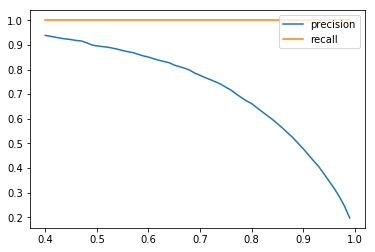

In [47]:
p=[]
r=[]
ts=[]

thresholds=np.arange(0.40, 1.00, 0.01)

y_true=target

for thres in thresholds:
    y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=thres else 0 )
    p1=precision_score(y_true=y_true, y_pred=y_pred, average=None)
    r1=recall_score(y_true=y_true, y_pred=y_pred, average=None)
    
    
    p.append(p1[1])
    r.append(r1[1])
    ts.append(thres)

plt.plot(ts,p,label='precision')    
plt.plot(ts,r,label='recall')    
plt.legend(loc='upper right')    

In [95]:
from sklearn.externals import joblib
joblib.dump(cb_clf, new_model, compress=3)

['fraudModelv1.2.pkl']